In [1]:
    # Importing required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from scipy.spatial import distance
import sys
import os

In [2]:
# Calling supporting functions for Simulation class
def blockPrint():
    '''
    The function suppresses printing. It is user in averaged_chart method to suppress printing of output of
    methods max_infected and peak_infected that is relevant only for 1 replication. The printing is enabled back via
    function enablePrint() below
    '''
    sys.stdout = open(os.devnull, 'w')


def enablePrint():
    '''
    The function enables printing of output that is turned off by function blockPrint(), see explanation above
    '''
    sys.stdout = sys.__stdout__

In [3]:
# Creating class Simulation
class Simulation:
    def __init__(self, m=40, n=25, r=6, k=20, alpha_infected=0.01, alpha_recovered=0,
                 beta_recovered=0.05, beta_dead=0.005, gamma=0.075, N=100):
        self.m = m
        self.n = n
        self.r = r
        self.k = k
        self.alpha_infected = alpha_infected
        self.alpha_recovered = alpha_recovered
        self.beta_recovered = beta_recovered
        self.beta_dead = beta_dead
        self.gamma = gamma
        self.N = N
        self.connections_number = 0
        self.max_connections = m*n*k/2
        self.connections = []
        self.individuals = pd.DataFrame()
        self.simulation_statistics = pd.DataFrame(dtype=float)
        self.stats_wide = pd.DataFrame(dtype=float)

        coordinates = []
        for i in range(m):
            for j in range(n):
                coordinates.append((j, i))
        initial_states = np.random.choice(["I", "R", "S"], len(coordinates), True,
                                          [self.alpha_infected, self.alpha_recovered,
                                           1-self.alpha_infected-self.alpha_recovered])

        self.individuals.insert(0, 'Coordinates', coordinates)
        self.individuals.insert(1, 'X coordinate', [i[0] for i in self.individuals['Coordinates']])
        self.individuals.insert(2, 'Y coordinate', [i[1] for i in self.individuals['Coordinates']])
        self.individuals.insert(3, 'Day 0', list(initial_states))

        comb = list(combinations(self.individuals['Coordinates'], 2))
        while self.connections_number < self.max_connections:
            rnd_indice = np.random.choice(len(comb), size=1)[0]
            new_connection = comb[rnd_indice]
            if distance.euclidean(new_connection[0], new_connection[1]) > r or new_connection in self.connections:
                pass
            else:
                self.connections.append(new_connection)
                self.connections_number += 1
        self.connections = pd.DataFrame(self.connections, columns=['Connection 1', 'Connection 2'])

        self.individuals = self.individuals.set_index('Coordinates')

    def run(self):
        for day in range(self.N):
            self.individuals[f'Day {day + 1}'] = ""
            for index, individual in self.individuals.iterrows():
                # if the person is infected
                if individual[f'Day {day}'] == 'I':
                    self.individuals.at[index, f'Day {day + 1}'] = np.random.choice(["R", "D", "I"],
                                                                                          1, True,
                                                                                          [self.beta_recovered, self.beta_dead,
                                                                                           1 - self.beta_recovered - self.beta_dead])[0]
                # if the person is susceptible
                elif individual[f'Day {day}'] == 'S':
                    conns = list(self.connections[self.connections['Connection 2'] == index]['Connection 1']) + \
                            list(self.connections[self.connections['Connection 1'] == index]['Connection 2'])

                    # an individual cannot be infected in case he/she is not infected and has no connections
                    if conns == []:
                        self.individuals.at[index, f'Day {day + 1}'] = self.individuals.at[index, f'Day {day}']
                    else:
                        for connection in conns:
                            if self.individuals.at[connection, f'Day {day}'] == 'I':
                                # every day there is a probability for a susceptible individual to be infected by
                                # each infected connection this individual has. The loop breaks in case an individual
                                # becomes infected.
                                self.individuals.at[index, f'Day {day + 1}'] = np.random.choice(["I", "S"], 1, True, [self.gamma, 1 - self.gamma])[0]
                                if self.individuals.at[index, f'Day {day + 1}'] == 'I':
                                    break
                            else:
                                self.individuals.at[index, f'Day {day + 1}'] = self.individuals.at[index, f'Day {day}']

                # in case the person is recovered or dead, its status does not change
                else:
                    self.individuals.at[index, f'Day {day + 1}'] = self.individuals.at[index, f'Day {day}']

        # collecting summary of the simulation
        self.simulation_statistics = pd.DataFrame(index=['New infections during the day', 'Infected at the end of the day',
                                                         'Recovered during the day',
                                                         'Accumulated recoveries at the end of the day',
                                                         'Deaths during the day',
                                                         'Accumulated deaths at the end of the day',
                                                         'Susceptible at the end of the day'],
                                                  columns=list(range(self.N+1)), dtype=float)
        self.simulation_statistics.loc['Infected at the end of the day'] = [sum(self.individuals[i] == "I") for i in self.individuals.columns[2:]]
        self.simulation_statistics.loc['Accumulated recoveries at the end of the day'] = [sum(self.individuals[i] == "R") for i in self.individuals.columns[2:]]
        self.simulation_statistics.loc['Accumulated deaths at the end of the day'] = [sum(self.individuals[i] == "D") for i in self.individuals.columns[2:]]
        self.simulation_statistics.loc['Susceptible at the end of the day'] = [sum(self.individuals[i] == "S") for i in self.individuals.columns[2:]]
        self.simulation_statistics.loc['Deaths during the day'] = [self.simulation_statistics.iat[5, i] if i == 0 else self.simulation_statistics.iat[5, i] - self.simulation_statistics.iat[5, i - 1] for i in range(len(self.simulation_statistics.columns))]
        self.simulation_statistics.loc['Recovered during the day'] = [self.simulation_statistics.iat[3, i] if i == 0 else self.simulation_statistics.iat[3, i] - self.simulation_statistics.iat[3, i - 1] for i in range(len(self.simulation_statistics.columns))]
        self.simulation_statistics.loc['New infections during the day'] = [self.simulation_statistics.iat[1, i] if i == 0 else self.simulation_statistics.iat[1, i] - self.simulation_statistics.iat[1, i - 1] + self.simulation_statistics.iat[2, i] + self.simulation_statistics.iat[4, i] for i in range(len(self.simulation_statistics.columns))]
        self.simulation_statistics = self.simulation_statistics.transpose()
        self.max_infected_number = float
        self.peak_infected_number = float

    def plot_state(self, day):
            '''Plot connections between individuals'''
            x_connections = []
            y_connections = []
            for index, connection in self.connections.iterrows():
                x_connections.append(connection['Connection 1'][0])
                x_connections.append(connection['Connection 2'][0])
                y_connections.append(connection['Connection 1'][1])
                y_connections.append(connection['Connection 2'][1])

            palette = {"S": "g", "I": "r", "R": "b", "D": "k"}
            plt.figure(figsize=(10, 8))
            for i in range(0, len(x_connections), 2):
                plt.plot(x_connections[i:i + 2], y_connections[i:i + 2], 'k-', linewidth=0.3, alpha=0.5)
            try:
                sns.scatterplot(x='X coordinate', y='Y coordinate', hue=f'Day {day}',
                                data=self.individuals, s=100, palette=palette)
            except ValueError:
                raise ValueError('Simulation needs to be carried out first. Run method run() of class Simulation instance'
                                 ' before running this method')

            plt.show()

    def chart(self, text='Plot of epidemic evolving over time'):
        try:
            self.stats_wide = self.simulation_statistics
            self.stats_wide.index = self.stats_wide.index.rename('Day')
            self.stats_wide = self.stats_wide.drop(['Recovered during the day',
                                                    'Deaths during the day',
                                                    'New infections during the day', ],
                                                   axis=1).melt(ignore_index=False).reset_index().groupby(
                ['Day', 'variable']).agg('mean').reset_index().rename(columns={'value': 'Number',
                                                                               'variable': 'Type'})
            plt.figure(figsize=(10, 6))
            sns.lineplot(x='Day', y='Number', data=self.stats_wide, hue='Type')
            plt.suptitle(t=text)
            plt.show()
        except KeyError:
            raise KeyError('Simulation needs to be carried out first. Run method run() of class Simulation instance'
                           ' before running this method')


    def max_infected(self):
        try:
            self.max_infected_number = self.simulation_statistics['Infected at the end of the day'].max()
            print(f'Infections reached maximum at {int(self.max_infected_number)} people')
        except KeyError:
            raise KeyError('Simulation needs to be carried out first. Run method run() of class Simulation instance'
                           ' before running this method')


    def peak_infected(self):
        try:
            self.peak_infected_day = self.simulation_statistics['Infected at the end of the day'].idxmax()
            print(f'Infections reached maximum on {self.peak_infected_day} day of epidemic')
        except KeyError:
            raise KeyError('Simulation needs to be carried out first. Run method run() of class Simulation instance'
                           ' before running this method')

    @staticmethod
    def averaged_chart(replications, m=40, n=25, r=6, k=20, alpha_infected=0.01, alpha_recovered=0,
                       beta_recovered=0.05, beta_dead=0.005, gamma=0.075, N=100):
        max_infected_mean = []
        peak_infected_mean = []
        for replication in range(replications):
            instance = Simulation(m, n, r, k, alpha_infected, alpha_recovered,beta_recovered,
                                  beta_dead, gamma, N)  # is put inside the loop as initial state is also random
                                                        # in order to carry out simulations with fixed random state
                                                        # this instance needs to be defined outside of the loop.

            instance.run()
            blockPrint()    # see description of the function in the beginning of the script
            instance.max_infected()
            instance.peak_infected()
            enablePrint()   # see description of the function in the beginning of the script
            instance.simulation_statistics['Replication'] = replication + 1
            max_infected_mean.append(instance.max_infected_number)
            peak_infected_mean.append(instance.peak_infected_day)
            if replication == 0:
                simulation_statistics_av = instance.simulation_statistics
            else:
                simulation_statistics_av = simulation_statistics_av.append(instance.simulation_statistics,
                                                                           ignore_index=False)
        instance.simulation_statistics = simulation_statistics_av.drop('Replication', axis=1)
        instance.chart(text=f'Plot of epidemic evolving over time ({replications} replications).{os.linesep}'
                            f'Average maximum infections of {np.mean(max_infected_mean)} people peaked '
                            f'on {np.mean(peak_infected_mean)} day')

In [4]:
# Initializing the simulation with default parameters
sim = Simulation()

In [5]:
# Carrying out the simulation
sim.run()

C:\Users\pankr\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


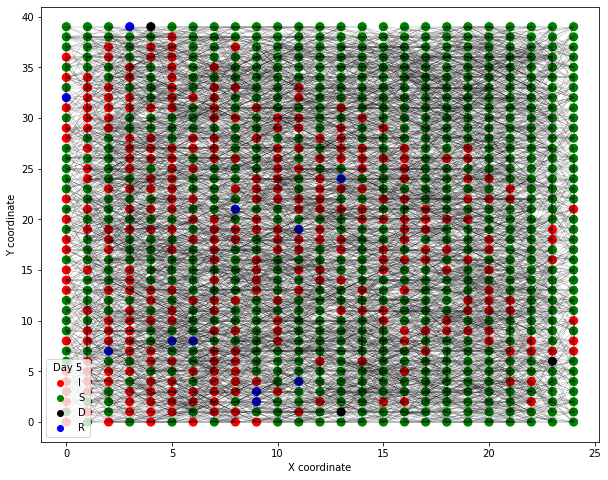

In [6]:
# Plotting state at day 5
sim.plot_state(5)

C:\Users\pankr\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


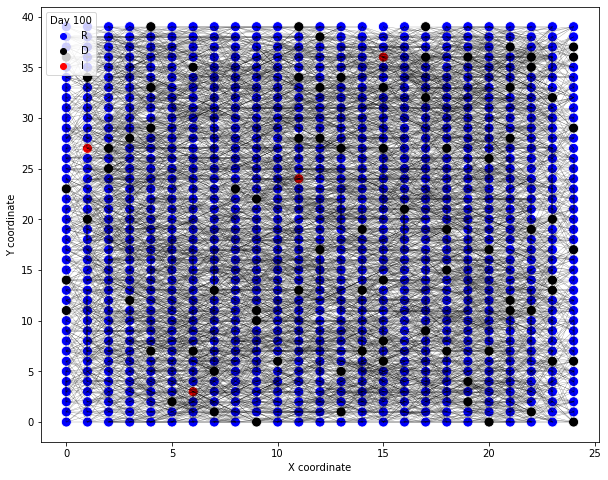

In [7]:
# Plotting state at day 100
sim.plot_state(100)

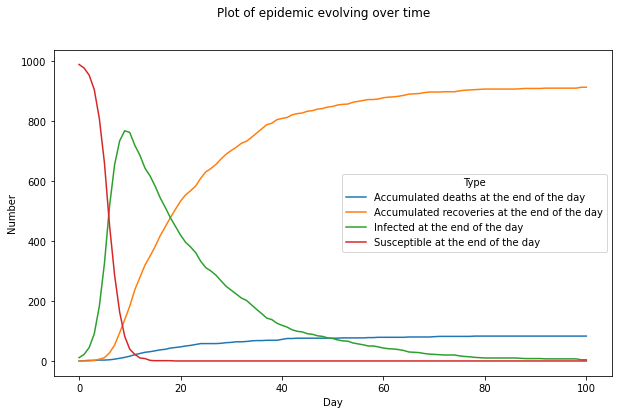

In [8]:
# Plotting chart of simulation results
sim.chart()

In [9]:
# Printing maximum infected
sim.max_infected()

Infections reached maximum at 768 people


In [10]:
# Printing peak day of infections
sim.peak_infected()

Infections reached maximum on 9 day of epidemic


C:\Users\pankr\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\pankr\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


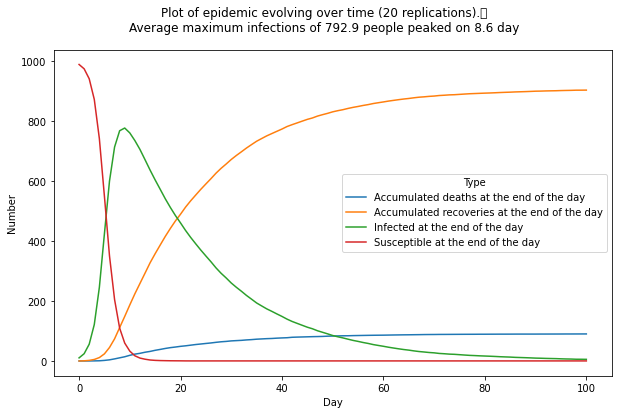

In [11]:
# Showing average chart of results of 20 replications and printing average max infections and averge peak day
# with default parameters
Simulation.averaged_chart(replications=20)

In [12]:
# Double checking the simulation with parameters used in the examples to the project requirements (r=2, k=4, N=200)
# Initializing and carrying out the simulation
sim_check = Simulation(k=4, r=2, N=200)
sim_check.run()

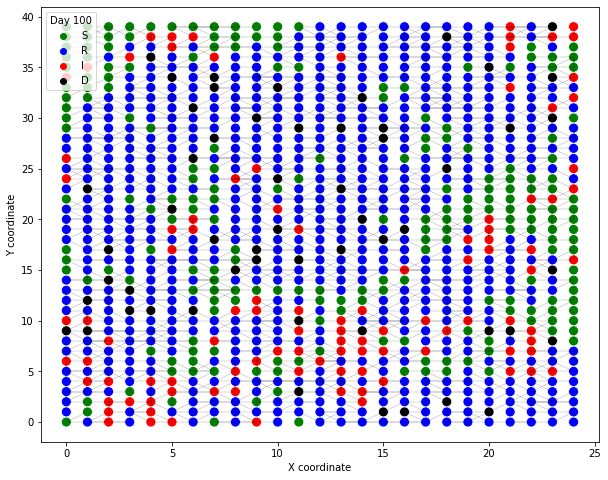

In [13]:
# Plotting state at day 100
sim_check.plot_state(100)

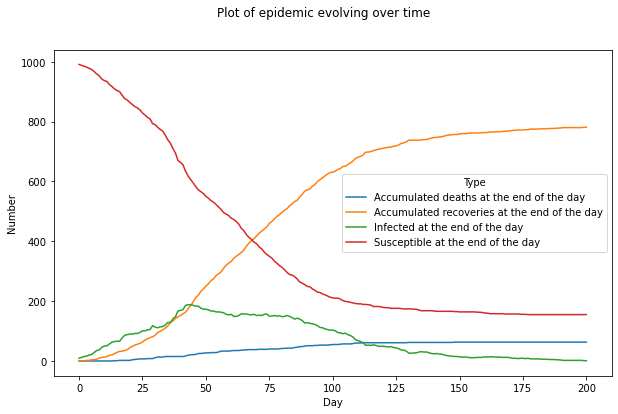

In [14]:
# Plotting chart
sim_check.chart()

C:\Users\pankr\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\pankr\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


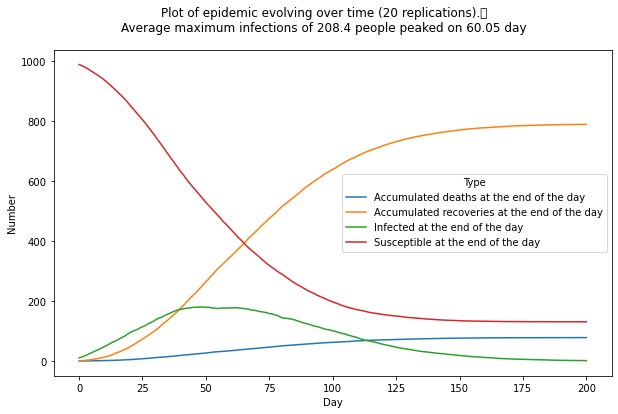

In [15]:
# Plotting average chart for 20 replications
Simulation.averaged_chart(replications=20, k=4, r=2, N=200)